This is an assignment that aims to explore the classification of text data using Support Vector Machine classifiers. It will include the preprocessing/cleaning of text data, followed by embedding, model fitting, feature importance, pipeline construction, and model optimization.

#### Importing Libraries

In [3]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import re

#### Exploring Data

In [4]:
#reading corpus.csv file from working directory
Corpus = pd.read_csv('./corpus.csv', encoding = 'latin-1')

In [5]:
#Displaying preview of dataframe
Corpus.head()

,text,label
0,Stuning even for the non-gamer: This sound tr...,__label__2
1,The best soundtrack ever to anything.: I'm re...,__label__2
2,Amazing!: This soundtrack is my favorite musi...,__label__2
3,Excellent Soundtrack: I truly like this sound...,__label__2
4,"Remember, Pull Your Jaw Off The Floor After H...",__label__2


In [6]:
#descriptive statistics
Corpus.describe()

,text,label
count,10000,10000
unique,10000,2
top,Great Book: The author did a great job. It is...,__label__1
freq,1,5097


In [7]:
#checking datatypes and missing/nan values
Corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
text     10000 non-null object
label    10000 non-null object
dtypes: object(2)
memory usage: 156.4+ KB


In [8]:
#checking number of labels in the target variable
Corpus['label'].value_counts()

__label__1     5097
__label__2     4903
Name: label, dtype: int64

#### Data pre-processing
This is an important step in any data mining process. 
This basically involves transforming raw data into an understandable format for NLP models. Real-world data is often incomplete, inconsistent, and/or lacking in certain behaviors or trends, and is likely to contain many errors. Data pre-processing is a proven method of resolving such issues.This will help in getting better results through the classification algorithms.

Below, I have explained the two techniques that are also performed besides other easy to understand steps in data pre-processing:

#### Tokenization: 


This is a process of breaking a stream of text up into words, phrases, symbols, or other meaningful elements called tokens. The list of tokens becomes input for further processing. NLTK Library has word_tokenize and sent_tokenize to easily break a stream of text into a list of words or sentences, respectively.


#### Word Stemming/Lemmatization: 


The aim of both processes is the same, reducing the inflectional forms of each word into a common base or root. Lemmatization is closely related to stemming. The difference is that a stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech. However, stemmers are typically easier to implement and run faster, and the reduced accuracy may not matter for some applications.


Here’s the complete script which performs the aforementioned data pre-processing steps, you can always add or remove steps which best suits the data set you are dealing with:

* Remove Blank rows in Data, if any
* Change all the text to lower case
* Word Tokenization
* Remove Stop words
* Remove Non-alpha text
* Word Lemmatization


In [9]:
# Step - a : Remove blank rows if any.
Corpus = Corpus.dropna(axis = 0)

# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
Corpus['text'] = Corpus['text'].str.lower()

# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
Corpus['text'] = Corpus['text'].apply(word_tokenize)

# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
Corpus['text'] = Corpus['text'].apply(lambda x: [re.sub(r'[^a-zA-Z]', '', w) for w in x])

stop_words = set(stopwords.words('english'))
Corpus['text'] = Corpus['text'].apply(lambda x: [w for w in x if w not in stop_words])

Corpus['text'] = Corpus['text'].apply(lambda x: [w for w in x if w])

Corpus['text'] = Corpus['text'].apply(pos_tag)
wnl = WordNetLemmatizer()

In [10]:
#defining function to convert pos_tag to format that is readable by WordNetLemmatizer
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'N':'n', 'J':'a',
                  'V':'v', 'R':'r'}
    try:
        return morphy_tag[penntag[:1]]
    except:
        return 'n' 

In [11]:
wnl.lemmatize('beautiful', pos = 'r')

'beautiful'

In [12]:
#applying penn2morphy function on corpus
Corpus['text_final'] = Corpus['text'].apply(lambda x: [wnl.lemmatize(w[0], pos = penn2morphy(w[1][0])) for w in x])

In [13]:
#joining final text together
Corpus['text_final'] = Corpus['text_final'].str.join(sep = ' ')

In [14]:
#previewing processed text
Corpus['text_final'].head()

0    stun even nongamer sound track beautiful paint...
1    best soundtrack ever anything reading lot revi...
2    amaze soundtrack favorite music time hand inte...
3    excellent soundtrack truly like soundtrack enj...
4    remember pull jaw floor hear played game know ...
Name: text_final, dtype: object

#### Preparing Test/ Train/ Datasets

In [15]:
# defining predictor and target features
X = Corpus['text_final']
y = Corpus['label']

In [16]:
#splitting data into training and testing with a 0.2 split for testing.
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

#### Encoding
Label encode the target variable — This is done to transform Categorical data of string type in the data set into numerical values which the model can understand.

In [17]:
#encoding the target variable using LabelEncoder
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

Now encoding the predictor variables. Text data needs to be converted into some numeric values which the model can understand and use for the prediction. Here, Term Frequency, Inverse Document Frequency (TF-IDF) is used. 

Term Frequency (TF) = (Number of times term appears in a document) / (Total Number of Terms in a document)
Inverse Document Frequency = log( (Total Number of Documents in Corpus) / (Number of Documents in Corpus Containing a Term) )

Term Frequency, Inverse Document Frequency (TF-IDF) = TF * IDF

In [18]:
#encoding the corpus using Term Frequency - Inverse Document Frequency Encoding
Tfidf_vect = TfidfVectorizer()

In [19]:
#fitting encoder on training data
Tfidf_vect.fit(Train_X)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [20]:
#Transforming the corpus for the training and testing data
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [21]:
#preview vocabulary vector
print(Tfidf_vect.vocabulary_)

{'perfect': 17596, 'first': 8935, 'grader': 10193, 'great': 10270, 'child': 3971, 'learn': 13528, 'basic': 1933, 'math': 14621, 'concept': 4726, 'really': 19483, 'help': 10921, 'gain': 9621, 'edge': 7332, 'fact': 8461, 'nt': 16399, 'waste': 26173, 'time': 24218, 'read': 19417, 'book': 2659, 'jeff': 12716, 'long': 14009, 'title': 24291, 'subject': 23089, 'though': 24080, 'start': 22713, 'bit': 2403, 'slow': 21999, 'take': 23539, 'speed': 22456, 'turn': 24860, 'one': 16701, 'best': 2252, 'ever': 8048, 'wonder': 26703, 'would': 26827, 'something': 22224, 'interesting': 12261, 'complex': 4656, 'psychological': 18958, 'video': 25845, 'represent': 20017, 'pretend': 18573, 'author': 1586, 'sue': 23166, 'travesty': 24651, 'bore': 2758, 'schlock': 20931, 'hollywood': 11177, 'representation': 20018, 'every': 8066, 'story': 22895, 'outlike': 17015, 'horror': 11291, 'movie': 15573, 'sell': 21200, 'well': 26331, 'please': 18033, 'like': 13772, 'idea': 11527, 'buy': 3258, 'entirely': 7796, 'comedy':

In [22]:
#preview transformed training data
print(Train_X_Tfidf)

  (0, 19483)	0.11051243356603122
  (0, 17596)	0.17211713520430952
  (0, 14621)	0.5319021275820398
  (0, 13528)	0.1667458746595442
  (0, 10921)	0.15427588136647652
  (0, 10270)	0.09354981436368018
  (0, 10193)	0.5665528800391814
  (0, 9621)	0.2440288407561642
  (0, 8935)	0.22815355007987512
  (0, 8461)	0.1576558281912403
  (0, 7332)	0.21601950631657574
  (0, 4726)	0.20482509898508713
  (0, 3971)	0.1644743829824821
  (0, 1933)	0.20438885462773088
  (1, 26827)	0.12603230050163222
  (1, 26703)	0.12689868779840224
  (1, 26331)	0.06877524624311661
  (1, 26173)	0.1929987535546437
  (1, 25845)	0.1091977771059753
  (1, 24860)	0.32816140529400695
  (1, 24651)	0.18539290913476877
  (1, 24291)	0.11931176235727581
  (1, 24218)	0.1290630779379649
  (1, 24080)	0.10162169509695967
  (1, 23539)	0.08017370076944065
  :	:
  (7999, 11024)	0.13582725677601176
  (7999, 9971)	0.1705025334771514
  (7999, 9825)	0.18424314191274488
  (7999, 9254)	0.13670844663133855
  (7999, 8946)	0.1660790455808876
  (7999, 88

#### Using the Machine Learning Algorithms

##### Simple Classifier

Since the target classes have approximately 50% representation each in the data, a simple classifier that predicts either of the classes can achieve a 50% accuracy. This will be the baseline to compare the model against.

##### SVM classifier

Let's first use a simple linear SVM to make the prediction.

In [23]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(kernel = 'linear')
SVM.fit(Train_X_Tfidf, Train_Y)

# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", SVM.score(Train_X_Tfidf, Train_Y)*100)
print("SVM Testing Accuracy Score -> ", SVM.score(Test_X_Tfidf, Test_Y)*100)

SVM Training Accuracy Score ->  96.28750000000001
SVM Testing Accuracy Score ->  83.45


The model does very well with an 86% accuracy on unseen data. However, the model does some overfitting since it can predict a lot better for seen than unseen data.

Since the target labels are ambigious, we can use the coefficients of the linear SVM models to attempt to understand what they could mean.

The coefficients of the linear SVM model will give insight as to which features (words in this case) are most useful in predicting the target label.

In [24]:
def plot_coefficients(classifier, feature_names, top_features=20):
    
    """This function visualizes the text features with the top n positive coefficients and the top n negative coefficients to
    gain insight as to what the strongest predictors of the target features are.
    
    classifier: an SVM classifier with a linear kernel
    feature_names: names of the features as provided by a TF-IDF embedder (accessed using the .get_feature_names attribute)
    top_features: the number of features with positive and negative coefficients to display, default value is 20
    """
    
    #converting coefficient matrix from sparse to dense and then unravelling it
    coef = np.ravel(classifier.coef_.reshape(-1, 1).todense())
    #getting the top n positive coefficients
    tpc = np.argsort(coef)[-top_features:]
    #getting the top n negative coefficients
    tnc = np.argsort(coef)[:top_features]
    #stacking them to form one array of top positive and negative coefficients
    top_coefficients = np.hstack([tnc, tpc])
    # creating plot
    plt.figure(figsize=(15, 5))
    #assigning color labels
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    #plotting data
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha = 'right')
    plt.xlabel("Feature Names")
    plt.ylabel("Linear SVM Coefficient")
    plt.show()

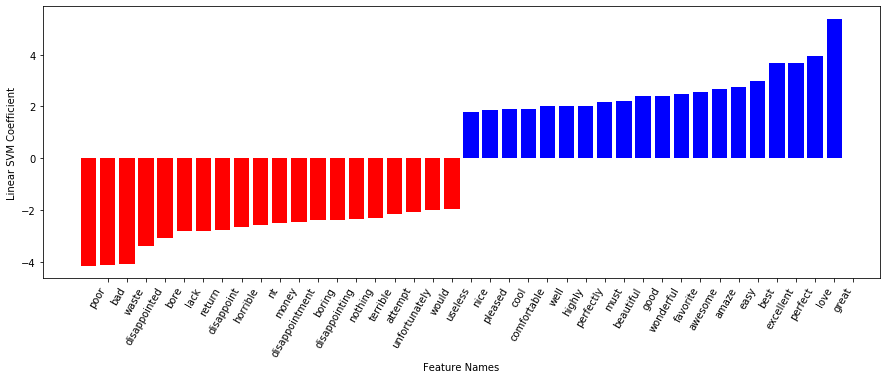

In [25]:
#plotting top n features and their coefficients
plot_coefficients(SVM, Tfidf_vect.get_feature_names())

Now we can get a better idea as to the meaning of the labels using the above plot. Negative coefficients are plotted in red while positive coefficients are plotted in blue. The feature names are listed on the x-axis.

Starting with the features with negative coefficients, we see that they correspond to words that have a negative connotation. These are words such as "poor", "waste", "bad", "bore" or "disappointment". On the other end of the spectrum, we see words that have positive connotations. These are words such as "great", "excellent", "love", "perfect" or "best".

Within the negative coefficient feature, as we move from right to left, the feature get a higher coefficient and the negative connotation grows. A similar observation can be made with positive coefficients and the words taking on a more positive correlation as we read from left to right.

We can therefore hypothesize that these labels correspond to a negative and positive sentiments or reviews of some sort as part of a sentiment analysis study.

#### Model Optimization

The model can be optimized by tuning its hyperparameters. There are hyperparamters in the SVM classifier as well as the TFIDF Vectorizer used to transform the data. As such, a pipeline will be initialized to be able to adjust both sets of hyperparameters.

In [26]:
#initializing tfidf vectorizer and an SVM classifier instance
tfidf = TfidfVectorizer()
clf = svm.SVC()

In [41]:
#constructing the pipeline
pipe = Pipeline([
    ('tfidf', tfidf),
    ('clf', clf)
])

In [42]:
#defining the search space for the hyper-parameters. In this case, a separate dictionaries are used since each kernel of the SVM
#model has restrictions on inputs. For example, a linear SVM has no use for the 'degree' or 'gamma' parameters and adjusting for
#them if the model is linear is simply inefficient. Therefore, we separate each kernel into its own dictionary and adjust only
#the paramters that are suitable for that kernel.

linear_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['linear']}
    
poly_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['poly'],
    'clf__degree' : [2, 3],
    'clf__gamma': np.logspace(-2, 2, 5)}

rbf_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['rbf'],
    'clf__gamma': np.logspace(-2, 2, 5)}

In [43]:
#using a randomized grid search to find the optimal value of the hyperparameters over a 5-fold cross-validation
scv_linear = RandomizedSearchCV(pipe, param_distributions = linear_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_linear.fit(Train_X, Train_Y);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.5min finished


In [44]:
#using a randomized grid search to find the optimal value of the hyperparameters over a 5-fold cross-validation
scv_poly = RandomizedSearchCV(pipe, param_distributions = poly_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_poly.fit(Train_X, Train_Y);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.1min finished


In [45]:
#using a randomized grid search to find the optimal value of the hyperparameters over a 5-fold cross-validation
scv_rbf = RandomizedSearchCV(pipe, param_distributions = rbf_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_rbf.fit(Train_X, Train_Y);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.6min finished


In [46]:
#preview randomized gridsearch results
pd.DataFrame(scv_linear.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]

,params,mean_train_score,mean_test_score
0,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.835656,0.815750
1,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.857406,0.829500
2,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.862937,0.810000
3,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",1.000000,0.822250
4,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.853219,0.814125
5,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",1.000000,0.799625
6,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.999906,0.823875
7,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.863281,0.811375
8,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.854844,0.815625
9,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",1.000000,0.822250


In [47]:
pd.DataFrame(scv_poly.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]

,params,mean_train_score,mean_test_score
0,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",1.00000,0.731625
1,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",1.00000,0.825875
2,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",1.00000,0.731375
3,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.50975,0.509750
4,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.50975,0.509750
5,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",1.00000,0.843125
6,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.50975,0.509750
7,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",1.00000,0.731375
8,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.50975,0.509750
9,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",1.00000,0.731375


In [49]:
pd.DataFrame(scv_rbf.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]

,params,mean_train_score,mean_test_score
0,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",1.000000,0.861000
1,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",1.000000,0.819750
2,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",1.000000,0.856625
3,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.509750,0.509750
4,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",1.000000,0.510125
5,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",1.000000,0.510000
6,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.996719,0.824750
7,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",1.000000,0.510750
8,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.509750,0.509750
9,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",1.000000,0.509750


Examing the parameters and scores generated by the randomized search, we see that the parameter combination with index 1 in the linear kernel dataframe has the best combination of high validation score and a similar training score. This means that the model generalizes pretty well over the 5 folds that were used to compute those scores. Thus, we will select this model to predict the test set.

In [51]:
#preview the best parameters as found by the gridsearch
scv_linear.best_params_

{'tfidf__ngram_range': (1, 3),
 'tfidf__max_features': 1000,
 'clf__kernel': 'linear',
 'clf__C': 0.1}

In [52]:
#selecting the classifier with the hyperparameters yielding the highest average cross-validation score
best_clf = scv_linear.best_estimator_

#### Model Evaluation

In [53]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", best_clf.score(Train_X, Train_Y)*100)
print("SVM Testing Accuracy Score -> ", best_clf.score(Test_X, Test_Y)*100)

SVM Training Accuracy Score ->  85.6375
SVM Testing Accuracy Score ->  83.05


In this case, the set of parameters with index 5 have been chosen and have decreased the testing score slightly (by about 0.45%) while reducing the training score by about 10%. This is desirable since we know have a simpler model that performs just as well on seen and unseen data. Thus, the model is consistent.

We will finish off with generating some curves and reports with sklearn that summarize our model performance.

In [54]:
#obtaining predictions and decision function scores
Pred_Y = best_clf.predict(Test_X)
Score_Y = best_clf.decision_function(Test_X)

##### Receiver Operating Characteristic (ROC) Curve

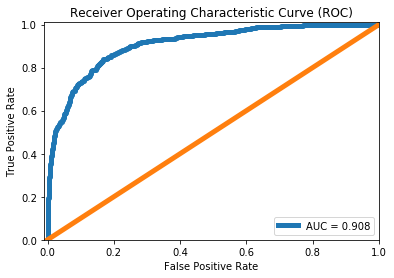

In [61]:
#plotting the Receiver Operating Characteristic (ROC) Curve
false_pos_rate, true_pos_rate, thresholds = roc_curve(Test_Y, Score_Y)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic Curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Our model (blue) has an area-under-curve (AUC) of ~0.91. This measure means our model has good separability between the classes. The orange line represent an AUC score of 0.5 which essential translates to a random model that hasn't really learned anything, cannot discriminate between classes and predicts at random (like the simple model we defined earlier).

##### Precision / Recall Curves

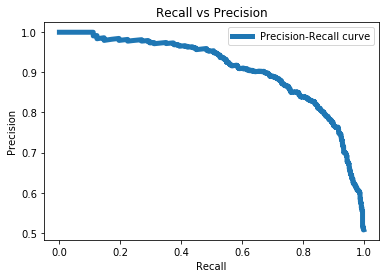

In [56]:
#Plotting Precision versus Recall
precision_rate, recall_rate, threshold_rate = precision_recall_curve(Test_Y, Score_Y)
plt.plot(recall_rate, precision_rate, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

The above plot displays precision vs recall for our model. In general, we expect precision to decrease as recall increases since there is a trade-off between the two metrics. The decline of precision as recall increases isn't that sharp until about a recall of 0.8. This is desirable since we want to maintain as a high a precision as we can while increasing recall.

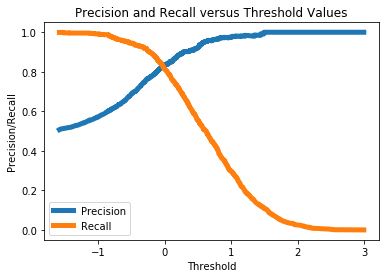

In [62]:
#Plotting Precision and Recall for different Threshold values
plt.plot(threshold_rate, precision_rate[1:], label="Precision",linewidth=5)
plt.plot(threshold_rate, recall_rate[1:], label="Recall",linewidth=5)
plt.title('Precision and Recall versus Threshold Values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

The plot above shows both precision and recall as a function of the threshold of the decision function used by our model to make the predictions. The Support Vector Classifier threshold translates to how close an observation is to the decision boundary. In the above plots, positive thresholds (>=0) predict one class while the negative threshold (<0) translate to prediction of the other class. The boundary lies at 0. This boundary gives us a precision and recall of slightly more than 0.8, a balance in the trade-off between the two metrics. In this problem, leaving the the threshold at zero is sufficient since we value both classes equally. In other applications, it might be desirable to use a different threshold depending on the cost of misclassification in the real-world.

##### Confusion matrix

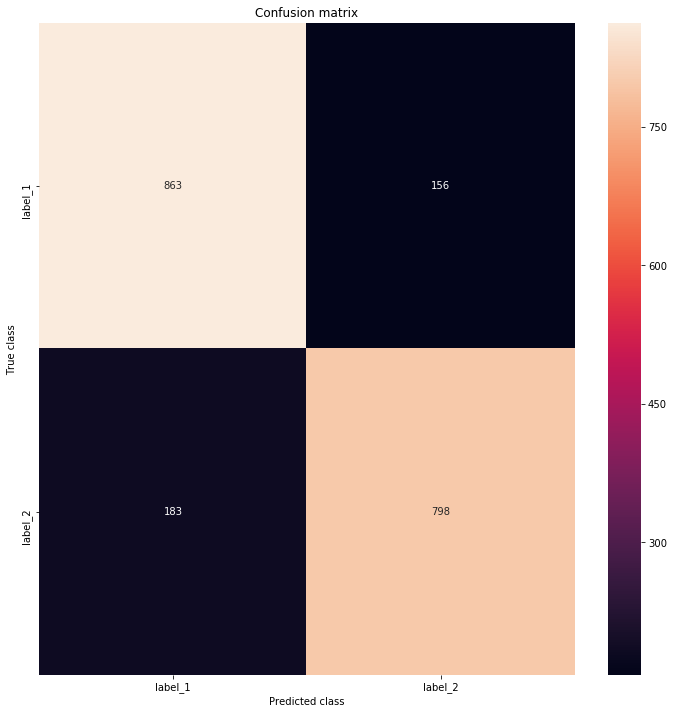

In [64]:
#creating and displaying confusion matrix
LABELS = ['label_1', 'label_2']
conf_matrix = confusion_matrix(Test_Y, Pred_Y)
plt.figure(figsize=(12, 12))
sb.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

With the true classes on the vertical axis and the predicted class on the horizontal axis, we can see how our model did for each class. The model is slightly better at predicting label_1 than label_2. Most of the error comes from the misclassification of label_2 as label_1 than the other way around.

##### Classification Report

Finally, here are metrics that summarize our model. The precision, recall and f1-score are pretty close to the 0.83 accuracy we obtained earlier since the classes are balanced.

In [59]:
#generating and printing a classification report
print(classification_report(Test_Y, Pred_Y))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1019
           1       0.84      0.81      0.82       981

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000

